In [1]:
import numpy as np
import pandas as pd

from scipy import linalg
from scipy import sparse
from scipy.sparse.linalg import svds
#import ot
import random
import itertools
import copy
import time as time
from matplotlib.pyplot import figure

from tqdm import tqdm
from sklearn.metrics import pairwise_distances
from scipy.stats import sem
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Functions 

## General

In [2]:
def signif(x, p):
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p-1))
    mags = 10 ** (p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags

def flatten_list(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def reverse_dict(dic):
    for r in dic.keys():
        if not isinstance(dic[r], list):
            dic[r] = [dic[r]]
    inverse = { v: k for k, l in dic.items() for v in l }
    return inverse

## Wasserstein Dimension Selection

In [3]:
def wasserstein_dim_select(Y, split = 0.5, rmax = 50):
    n = Y.shape[0]
    train = round(n * split)
    rtry = int(np.min((train, rmax)))
    if sparse.issparse(Y):
        Y = Y.todense()
    Ytrain = Y[:train,:]
    Ytest = Y[train:n,:]
    U, s, Vh = sparse.linalg.svds(Ytrain,k=rtry-1)
    idx = s.argsort()[::-1] 
    s = s[idx]
    Vh = Vh[idx,:]
    ws = []
    for r in tqdm(range(1,rtry+1)):
        P = Vh.T[:,:r] @ Vh[:r,:]
        Yproj = Ytrain @ P.T
        n1 = Yproj.shape[0]
        n2 = Ytest.shape[0]
        M = ot.dist(Yproj,Ytest, metric='euclidean')
        W1 = ot.emd2(np.repeat(1/n1,n1),np.repeat(1/n2,n2),M)
        ws.append(W1)
    return ws

## PC Scores

In [4]:
def pc_scores(X, r):
    U, s, Vh = svds(X,k=r)
    idx = s.argsort()[::-1]   
    Vh = Vh[idx,:]
    Y = X @ Vh.T
    return Y

def embed_cov(X, r):
    if r == X.shape[0]:
        U, s, Vh = np.linalg.svd(X, full_matrices=True)
    else:
        U, s, Vh = svds(X,k=r)
    idx = s.argsort()[::-1]   
    U = U[:,idx]
    s = s[idx]
    ## need to take square root as these are eigenvalues
    Y = U @ np.diag(np.sqrt(s)) 
    return Y

def inner_products(X):
    return X.dot(X.T)

## Inner Product Hierarchical Clustering

In [5]:
def find_rows_to_merge(F):
    f = copy.deepcopy(F)
    np.fill_diagonal(f, -np.inf)
    idx = np.unravel_index(f.argmax(), f.shape)
    return np.array(idx)

def inner_products(X):
    return X.dot(X.T)

In [6]:
def clusters_to_labels(clusters):
    d = defaultdict(list)
    for index, sublist in enumerate(clusters):
        for item in sublist:
            d[item].append(index)
    labels = flatten_list([d[c] for c in range(len(d.keys()))])
    return labels

In [7]:
# def ip_metric(X,Y):
#     return  np.exp(-np.sum(X * Y))

# def ip_affinity(X):
#     return pairwise_distances(X, metric = ip_metric)

def ip_metric(X,Y):
    return  np.sum(X * Y)

def ip_affinity(X):
    ips = pairwise_distances(X, metric = ip_metric)
    return np.max(ips) - ips

## Simulate tree

In [8]:
def find_tree_paths(observed_nodes, tree_dict):
    if observed_nodes == 'leaf':
        Z = np.array(list(set(tree_dict.keys()) - set(tree_dict.values())))
    elif observed_nodes == 'all':
        Z = np.array(list(set(list(tree_dict.keys()) + list(tree_dict.values()))))
    else:
        Z = np.array(observed_nodes)
    origin_node = list(set(tree_dict.values()) - set(tree_dict.keys()))[0]
    paths  = []
    for z in Z:
        path = [z]
        if z == origin_node:
            paths.append([z])
        else:
            while True:
                parent_node =  tree_dict[path[-1]]
                path = path + [parent_node]
                if parent_node == origin_node:
                    path.reverse()
                    paths.append(path)
                    break
    return paths

def make_tree_cov(paths,variance_dict, root_mean =0):
    path_comb = list(itertools.product(paths, paths))
    varis = []
    for pair in path_comb:
        inter = list(set(pair[0]).intersection(pair[1]))
        var = np.sum([variance_dict[i] for i in inter])
        varis.append(var)
    F = np.array(varis).reshape((int(np.sqrt(len(varis))),int(np.sqrt(len(varis)))))
    return F + root_mean**2

In [9]:
## makes X (no added noise)
def make_X_by_tree(observed_nodes, tree_dict,root_mean, variance_dict,n,p):
    if observed_nodes == 'leaf':
        Z = np.array(list(set(tree_dict.keys()) - set(tree_dict.values())))
    elif observed_nodes == 'all':
        Z = np.array(list(variance_dict.keys()))
    else:
        Z = np.array(observed_nodes)
    zs = np.array(random.choices(Z, k=n)) # samples
    origin_node = list(set(tree_dict.values()) - set(tree_dict.keys()))[0] # root node 
    paths  = find_tree_paths(Z, tree_dict)
    path_comb = list(itertools.product(paths, paths))
    nodes = list(variance_dict.keys())
    sns = {no: np.random.normal(0, np.sqrt(variance_dict[no]), p) for no in list(set(nodes) - set([origin_node]))}
    sns[origin_node] = np.random.normal(root_mean, np.sqrt(variance_dict[origin_node]), p)
    mus = np.array([np.sum([sns[i] for i in path],axis = 0) for path in paths])
    X = mus[zs-1]
    labels = zs
    return X, labels

In [10]:
## makes Y with S*E noise 
def make_Y_by_tree(observed_nodes, tree_dict,root_mean, variance_dict, noise_dict, n,p):
    if observed_nodes == 'leaf':
        Z = np.array(list(set(tree_dict.keys()) - set(tree_dict.values())))
    elif observed_nodes == 'all':
        Z = np.array(list(variance_dict.keys()))
    else:
        Z = np.array(observed_nodes)
    zs = np.array(random.choices(Z, k=n)) # samples
    origin_node = list(set(tree_dict.values()) - set(tree_dict.keys()))[0] # root node 
    paths  = find_tree_paths(Z, tree_dict)
    path_comb = list(itertools.product(paths, paths))
    nodes = list(variance_dict.keys())
    sns = {no: np.random.normal(0, np.sqrt(variance_dict[no]), p) for no in list(set(nodes) - set([origin_node]))}
    sns[origin_node] = np.random.normal(root_mean, np.sqrt(variance_dict[origin_node]), p)
    mus = np.array([np.sum([sns[i] for i in path],axis = 0) for path in paths])
    X = mus[zs-1]
    labels = zs
    
    s = noise_dict[next(iter(noise_dict))].shape[1]
    SE = np.array([noise_dict[z] @  np.random.normal(0,sigma,s) for z in zs]) # multiple noise matrix by E_i
    
    Y = X + SE 
    return Y, labels

# Generate data

# inner product errors

### tree structure

In [11]:
sigma = 1
root_mean = 0

# defines the tree, 1:6 means 6 is a parent of 1 
tree_dict = {1:6, 2:6, 3:6, 4:7, 5:7, 6:8, 7:8}

# variance of each gaussian increment
# 1:1 means the branch length between 1 and it's parent is 1
variance_dict = {1: 5, 2: 2, 3: 2, 4: 0.5, 5: 7, 6: 2, 7: 1, 8: 1} 

# which vertices we have samples from
realised_nodes = 'leaf'

# number of simulations
n_sim = 100

### first scaling relationship

In [17]:
#n and p growing
#ns = list(range(100, 1100, 100))
#ps_arry = np.round(1+np.log(ns))
#ps_arry = ps_arry - ps_arry.min() +10
#ps = list(ps_arry)

#n fixed and p growing
#ps = list(range(100, 1100, 100))
#ns = [10]*len(ps)

#p fixed and n growing
ns = list(range(100, 1100, 100))
ps = [10]*len(ps)


Ps = []
Ns = []
df = pd.DataFrame(columns = ['n', 'p', 'p/n', 
                   'off_diag_Y_error_max', 'off_diag_zeta_error_max', 
                   'off_diag_Y_se_max', 'off_diag_zeta_se_max', 
                   'off_diag_Y_error_average', 'off_diag_zeta_error_average',
                  'off_diag_Y_se_average', 'off_diag_zeta_se_average',    
                             ])




F = make_tree_cov(find_tree_paths(realised_nodes, tree_dict), variance_dict,root_mean)

centers = embed_cov(F,F.shape[0])

for i in tqdm(range(len(ps))):
        p = int(ps[i])
        n = ns[i]
        pairs = list(itertools.combinations(range(n),2))
        
        off_diag_Y_max_errors = []
        off_diag_zeta_max_errors = []
        off_diag_Y_average_errors = []
        off_diag_zeta_average_errors = []
        for i in range(n_sim):
            X,labels = make_X_by_tree(realised_nodes, tree_dict,root_mean, variance_dict,n,p)
            Y = X + np.random.normal(0,sigma,X.shape)
               
            Y_ips = (1/p)* Y @ Y.T
            dim = len(list(set(labels)))
            zeta =  p**-.5 * pc_scores(Y,dim)           
            phi = centers[(labels-1)]
            
            F1 = phi @ phi.T 
            
            zeta_ips = zeta @ zeta.T
            
            np.fill_diagonal(Y_ips, 0)
            np.fill_diagonal(F1, 0)
            np.fill_diagonal(zeta_ips, 0)
            
            off_diag_Y_max_errors.append(np.max(np.abs(Y_ips - F1)))
            off_diag_zeta_max_errors.append(np.max(np.abs(zeta_ips - F1)))
            
            off_diag_Y_average_errors.append(np.mean(np.abs(Y_ips - F1)))
            off_diag_zeta_average_errors.append(np.mean(np.abs(zeta_ips - F1)))
            
            
        new_row = {'n': n, 'p': p , 'p/n': p/n, 
                
                   'off_diag_Y_error_max':np.mean(off_diag_Y_max_errors), 'off_diag_zeta_error_max':np.mean(off_diag_zeta_max_errors), 
                   'off_diag_Y_se_max': sem(off_diag_Y_max_errors), 'off_diag_zeta_se_max': sem(off_diag_zeta_max_errors), 
                   'off_diag_Y_error_average':np.mean(off_diag_Y_average_errors), 'off_diag_zeta_error_average':np.mean(off_diag_zeta_average_errors),
                  'off_diag_Y_se_average': sem(off_diag_Y_average_errors), 'off_diag_zeta_se_average': sem(off_diag_zeta_average_errors),
                   
                  
                  }
        df = pd.concat([df,pd.DataFrame(new_row, index=[0])]).reset_index(drop=True)

100%|██████████| 10/10 [00:18<00:00,  1.81s/it]


In [16]:
df1 = df

In [14]:
df_nconst_1 = df

In [18]:
df_pconst_1 = df

### second scaling relationship

In [24]:
#n and p both growing
#ns = list(range(100, 1100, 100))
#ps_arry = np.round(np.sqrt(ns))
#ps_arry = ps_arry - ps_arry.min() +10
#ps = list(ps_arry)

#n fixed and p growing
#ps = list(range(100, 1100, 100))
#ns = [100]*len(ps)

#p fixed and n growing
ns = list(range(100, 1100, 100))
ps = [100]*len(ps)



Ps = []
Ns = []
df = pd.DataFrame(columns = ['n', 'p', 'p/n', 
                   'off_diag_Y_error_max', 'off_diag_zeta_error_max', 
                   'off_diag_Y_se_max', 'off_diag_zeta_se_max', 
                   'off_diag_Y_error_average', 'off_diag_zeta_error_average',
                  'off_diag_Y_se_average', 'off_diag_zeta_se_average',    
                             ])




F = make_tree_cov(find_tree_paths(realised_nodes, tree_dict), variance_dict,root_mean)

centers = embed_cov(F,F.shape[0])

for i in tqdm(range(len(ps))):
        p = int(ps[i])
        n = ns[i]
        pairs = list(itertools.combinations(range(n),2))
        
        off_diag_Y_max_errors = []
        off_diag_zeta_max_errors = []
        off_diag_Y_average_errors = []
        off_diag_zeta_average_errors = []
        for i in range(n_sim):
            
            X,labels = make_X_by_tree(realised_nodes, tree_dict,root_mean, variance_dict,n,p)
            Y = X + np.random.normal(0,sigma,X.shape)
                        
            Y_ips = (1/p)* Y @ Y.T
            dim = len(list(set(labels)))
            zeta =  p**-.5 * pc_scores(Y,dim)
            
            phi = centers[(labels-1)]
            
            F1 = phi @ phi.T 
            
            zeta_ips = zeta @ zeta.T
            
            np.fill_diagonal(Y_ips, 0)
            np.fill_diagonal(F1, 0)
            np.fill_diagonal(zeta_ips, 0)
            
            off_diag_Y_max_errors.append(np.max(np.abs(Y_ips - F1)))
            off_diag_zeta_max_errors.append(np.max(np.abs(zeta_ips - F1)))
            
            off_diag_Y_average_errors.append(np.mean(np.abs(Y_ips - F1)))
            off_diag_zeta_average_errors.append(np.mean(np.abs(zeta_ips - F1)))
            
            
        new_row = {'n': n, 'p': p , 'p/n': p/n, 
                
                   'off_diag_Y_error_max':np.mean(off_diag_Y_max_errors), 'off_diag_zeta_error_max':np.mean(off_diag_zeta_max_errors), 
                   'off_diag_Y_se_max': sem(off_diag_Y_max_errors), 'off_diag_zeta_se_max': sem(off_diag_zeta_max_errors), 
                   'off_diag_Y_error_average':np.mean(off_diag_Y_average_errors), 'off_diag_zeta_error_average':np.mean(off_diag_zeta_average_errors),
                  'off_diag_Y_se_average': sem(off_diag_Y_average_errors), 'off_diag_zeta_se_average': sem(off_diag_zeta_average_errors),
                   
                  
                  }
        df = pd.concat([df,pd.DataFrame(new_row, index=[0])]).reset_index(drop=True)

100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


In [21]:
df2 = df

In [23]:
df_nconst_2 = df

In [25]:
df_pconst_2 = df

### third scaling relationship

In [30]:
#n and p both growin
#ns = list(range(100, 1100, 100))
#ps_arry = np.round(ns/np.round(np.log(ns)))
#ps_arry = ps_arry - ps_arry.min() +10
#ps = list(ps_arry)

#n fixed and p growing
#ps = list(range(100, 1100, 100))
#ns = [1000]*len(ps)

#p fixed and n growing
ns = list(range(100, 1100, 100))
ps = [1000]*len(ps)



Ps = []
Ns = []
df = pd.DataFrame(columns = ['n', 'p', 'p/n', 
                   'off_diag_Y_error_max', 'off_diag_zeta_error_max', 
                   'off_diag_Y_se_max', 'off_diag_zeta_se_max', 
                   'off_diag_Y_error_average', 'off_diag_zeta_error_average',
                  'off_diag_Y_se_average', 'off_diag_zeta_se_average',    
                             ])




F = make_tree_cov(find_tree_paths(realised_nodes, tree_dict), variance_dict,root_mean)
centers = embed_cov(F,F.shape[0])


for i in tqdm(range(len(ps))):
        p = int(ps[i])
        n = ns[i]
        pairs = list(itertools.combinations(range(n),2))
        
        off_diag_Y_max_errors = []
        off_diag_zeta_max_errors = []
        off_diag_Y_average_errors = []
        off_diag_zeta_average_errors = []
        for i in range(n_sim):
            X,labels = make_X_by_tree(realised_nodes, tree_dict,root_mean, variance_dict,n,p)
            Y = X + np.random.normal(0,sigma,X.shape)            
            
            Y_ips = (1/p)* Y @ Y.T
            dim = len(list(set(labels)))
            zeta =  p**-.5 * pc_scores(Y,dim)
            
            phi = centers[(labels-1)]
            
            F1 = phi @ phi.T 
            
            zeta_ips = zeta @ zeta.T
            
            np.fill_diagonal(Y_ips, 0)
            np.fill_diagonal(F1, 0)
            np.fill_diagonal(zeta_ips, 0)
            
            off_diag_Y_max_errors.append(np.max(np.abs(Y_ips - F1)))
            off_diag_zeta_max_errors.append(np.max(np.abs(zeta_ips - F1)))
            
            off_diag_Y_average_errors.append(np.mean(np.abs(Y_ips - F1)))
            off_diag_zeta_average_errors.append(np.mean(np.abs(zeta_ips - F1)))
            
            
        new_row = {'n': n, 'p': p , 'p/n': p/n, 
                
                   'off_diag_Y_error_max':np.mean(off_diag_Y_max_errors), 'off_diag_zeta_error_max':np.mean(off_diag_zeta_max_errors), 
                   'off_diag_Y_se_max': sem(off_diag_Y_max_errors), 'off_diag_zeta_se_max': sem(off_diag_zeta_max_errors), 
                   'off_diag_Y_error_average':np.mean(off_diag_Y_average_errors), 'off_diag_zeta_error_average':np.mean(off_diag_zeta_average_errors),
                  'off_diag_Y_se_average': sem(off_diag_Y_average_errors), 'off_diag_zeta_se_average': sem(off_diag_zeta_average_errors),
                   
                  }
        df = pd.concat([df,pd.DataFrame(new_row, index=[0])]).reset_index(drop=True)

100%|██████████| 10/10 [00:50<00:00,  5.00s/it]


In [27]:
df3 = df

In [29]:
df_nconst_3 = df

In [31]:
df_pconst_3 = df

### fourth scaling relationship

In [32]:
ns = list(range(100, 1100, 100))
ps_arry = np.round(ns)
ps_arry = ps_arry - ps_arry.min() +10
ps = list(ps_arry)


Ps = []
Ns = []
df = pd.DataFrame(columns = ['n', 'p', 'p/n', 
                   'off_diag_Y_error_max', 'off_diag_zeta_error_max', 
                   'off_diag_Y_se_max', 'off_diag_zeta_se_max', 
                   'off_diag_Y_error_average', 'off_diag_zeta_error_average',
                  'off_diag_Y_se_average', 'off_diag_zeta_se_average',    
                             ])


F = make_tree_cov(find_tree_paths(realised_nodes, tree_dict), variance_dict,root_mean)
centers = embed_cov(F,F.shape[0])


for i in tqdm(range(len(ps))):
        p = int(ps[i])
        n = ns[i]
        pairs = list(itertools.combinations(range(n),2))
        
        off_diag_Y_max_errors = []
        off_diag_zeta_max_errors = []
        off_diag_Y_average_errors = []
        off_diag_zeta_average_errors = []
        for i in range(n_sim):
            X,labels = make_X_by_tree(realised_nodes, tree_dict,root_mean, variance_dict,n,p)
            Y = X + np.random.normal(0,sigma,X.shape)            
            
            Y_ips = (1/p)* Y @ Y.T
            dim = len(list(set(labels)))
            zeta =  p**-.5 * pc_scores(Y,dim)
            
            phi = centers[(labels-1)]
            
            F1 = phi @ phi.T 
            
            zeta_ips = zeta @ zeta.T
            
            np.fill_diagonal(Y_ips, 0)
            np.fill_diagonal(F1, 0)
            np.fill_diagonal(zeta_ips, 0)
            
            off_diag_Y_max_errors.append(np.max(np.abs(Y_ips - F1)))
            off_diag_zeta_max_errors.append(np.max(np.abs(zeta_ips - F1)))
            
            off_diag_Y_average_errors.append(np.mean(np.abs(Y_ips - F1)))
            off_diag_zeta_average_errors.append(np.mean(np.abs(zeta_ips - F1)))
            
            
        new_row = {'n': n, 'p': p , 'p/n': p/n, 
                
                   'off_diag_Y_error_max':np.mean(off_diag_Y_max_errors), 'off_diag_zeta_error_max':np.mean(off_diag_zeta_max_errors), 
                   'off_diag_Y_se_max': sem(off_diag_Y_max_errors), 'off_diag_zeta_se_max': sem(off_diag_zeta_max_errors), 
                   'off_diag_Y_error_average':np.mean(off_diag_Y_average_errors), 'off_diag_zeta_error_average':np.mean(off_diag_zeta_average_errors),
                  'off_diag_Y_se_average': sem(off_diag_Y_average_errors), 'off_diag_zeta_se_average': sem(off_diag_zeta_average_errors),
                   
                  }
        df = pd.concat([df,pd.DataFrame(new_row, index=[0])]).reset_index(drop=True)

100%|██████████| 10/10 [00:39<00:00,  3.99s/it]


In [34]:
df4 = df

### plotting

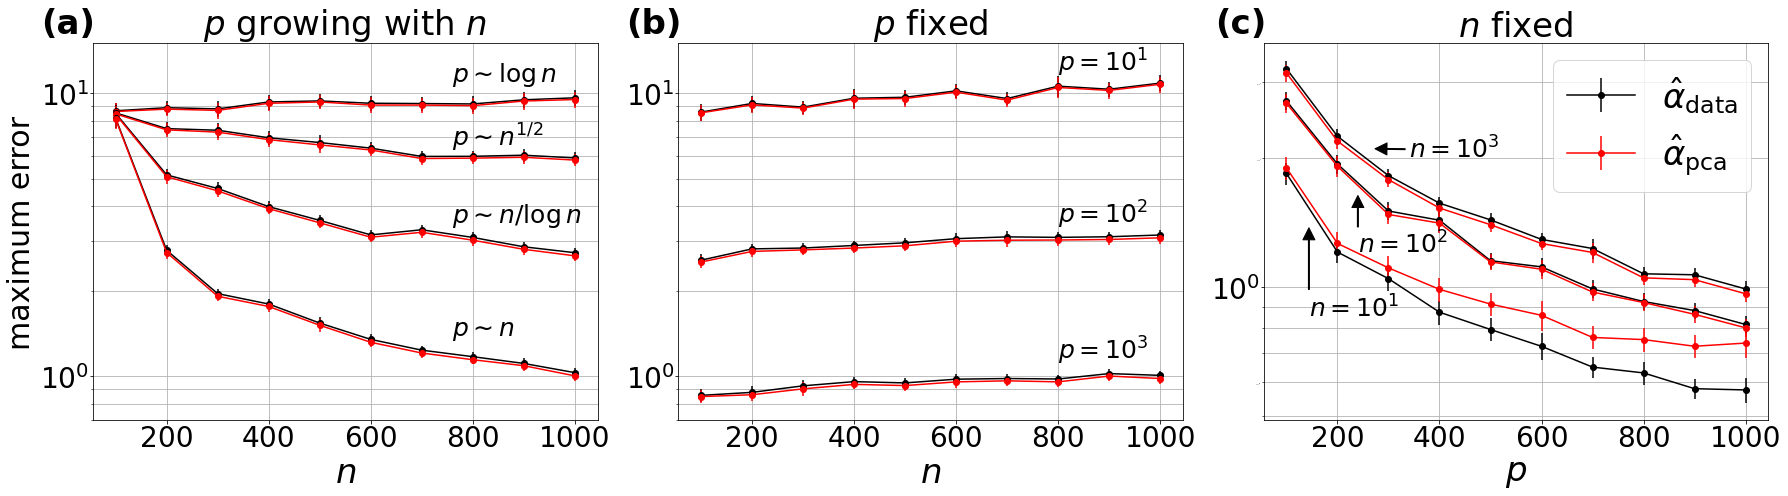

In [21]:
fig,ax = plt.subplots(1,3,figsize = (25,7))

df_plot = df1
ax[0].errorbar(df_plot['n'],df_plot['off_diag_Y_error_max'], yerr=2*df_plot['off_diag_Y_se_max'],fmt='-o',c='black')
ax[0].errorbar(df_plot['n'],df_plot['off_diag_zeta_error_max'], yerr=2*df_plot['off_diag_zeta_se_max'],fmt='-o',c='red')

df_plot = df2
ax[0].errorbar(df_plot['n'],df_plot['off_diag_Y_error_max'], yerr=2*df_plot['off_diag_Y_se_max'],fmt='-o',c='black')
ax[0].errorbar(df_plot['n'],df_plot['off_diag_zeta_error_max'], yerr=2*df_plot['off_diag_zeta_se_max'],fmt='-o',c='red')


df_plot = df3
ax[0].errorbar(df_plot['n'],df_plot['off_diag_Y_error_max'], yerr=2*df_plot['off_diag_Y_se_max'],fmt='-o',c='black')
ax[0].errorbar(df_plot['n'],df_plot['off_diag_zeta_error_max'], yerr=2*df_plot['off_diag_zeta_se_max'],fmt='-o',c='red')


df_plot = df4
ax[0].errorbar(df_plot['n'],df_plot['off_diag_Y_error_max'], yerr=2*df_plot['off_diag_Y_se_max'],fmt='-o',c='black')
ax[0].errorbar(df_plot['n'],df_plot['off_diag_zeta_error_max'], yerr=2*df_plot['off_diag_zeta_se_max'],fmt='-o',c='red')



ax[0].set_yscale('log')
ax[0].set_xlabel('$n$',fontsize = 34)
ax[0].set_ylim(top = 15, bottom = 0.7)
ax[0].set_ylabel('maximum error',fontsize = 30)
ax[0].tick_params(axis='x', labelsize=28,pad=0)
ax[0].tick_params(axis='y', labelsize=28,pad=0)
ax[0].set_title(r'$p$ growing with $n$',fontsize =34)
ax[0].grid(visible=True,which='both',axis='both')

ax[0].text(x=760,y=11,s='$p\sim\log n$', fontsize = 25)
ax[0].text(x=760,y=6.5,s='$p\sim n^{1/2}$', fontsize = 25)
ax[0].text(x=760,y=3.5,s='$p\sim n/\log n$', fontsize = 25)
ax[0].text(x=760,y=1.4,s='$p\sim n $', fontsize = 25)




df_plot = df_nconst_1
ax[2].errorbar(df_plot['p'],df_plot['off_diag_Y_error_max'], yerr=2*df_plot['off_diag_Y_se_max'],fmt='-o',c='black',label = r'$ \hat{\alpha}_{\mathrm{data}}$')
ax[2].errorbar(df_plot['p'],df_plot['off_diag_zeta_error_max'], yerr=2*df_plot['off_diag_zeta_se_max'],fmt='-o',c='red',label = r'$ \hat{\alpha}_{\mathrm{pca}}$')

df_plot = df_nconst_2
ax[2].errorbar(df_plot['p'],df_plot['off_diag_Y_error_max'], yerr=2*df_plot['off_diag_Y_se_max'],fmt='-o',c='black')
ax[2].errorbar(df_plot['p'],df_plot['off_diag_zeta_error_max'], yerr=2*df_plot['off_diag_zeta_se_max'],fmt='-o',c='red')

df_plot = df_nconst_3
ax[2].errorbar(df_plot['p'],df_plot['off_diag_Y_error_max'], yerr=2*df_plot['off_diag_Y_se_max'],fmt='-o',c='black')
ax[2].errorbar(df_plot['p'],df_plot['off_diag_zeta_error_max'], yerr=2*df_plot['off_diag_zeta_se_max'],fmt='-o',c='red')


ax[2].set_yscale('log')
ax[2].set_xlabel('$p$',fontsize = 34)
#ax[2].set_ylabel('Maximum error',fontsize = 16)
ax[2].tick_params(axis='x', labelsize=28,pad=0)
ax[2].tick_params(axis='y', labelsize=28,pad=0)
ax[2].tick_params(axis='y', which = 'minor', labelsize=0,pad=0)
ax[2].set_title(r'$n$ fixed',fontsize =34)
ax[2].grid(visible=True,which='both',axis='both')
ax[2].legend(loc='upper right', prop={'size': 34});


ax[2].annotate('$n=10^1$', (144, 1.4), xytext=(144, 0.85),    arrowprops=dict(width=1, facecolor='black', shrink=0.05), fontsize = 25)
ax[2].annotate('$n=10^2$', xy=(240, 1.65), xytext=(240, 1.2),    arrowprops=dict(width=1, facecolor='black', shrink=0.05), fontsize = 25)
ax[2].annotate('$n=10^3$', xy=(270, 2.1), xytext=(340, 2),    arrowprops=dict(width=1, facecolor='black', shrink=0.05), fontsize = 25)

#no arrows
#ax[2].text(x=140,y=0.85,s='$n=10^1$', fontsize = 25)
#ax[2].text(x=240,y=1.2,s='$n=10^2$', fontsize = 25)
#ax[2].text(x=330,y=2,s='$n=10^3$', fontsize = 25)

df_plot = df_pconst_1
ax[1].errorbar(df_plot['n'],df_plot['off_diag_Y_error_max'], yerr=2*df_plot['off_diag_Y_se_max'],fmt='-o',c='black')
ax[1].errorbar(df_plot['n'],df_plot['off_diag_zeta_error_max'], yerr=2*df_plot['off_diag_zeta_se_max'],fmt='-o',c='red')

df_plot = df_pconst_2
ax[1].errorbar(df_plot['n'],df_plot['off_diag_Y_error_max'], yerr=2*df_plot['off_diag_Y_se_max'],fmt='-o',c='black')
ax[1].errorbar(df_plot['n'],df_plot['off_diag_zeta_error_max'], yerr=2*df_plot['off_diag_zeta_se_max'],fmt='-o',c='red')

df_plot = df_pconst_3
ax[1].errorbar(df_plot['n'],df_plot['off_diag_Y_error_max'], yerr=2*df_plot['off_diag_Y_se_max'],fmt='-o',c='black')
ax[1].errorbar(df_plot['n'],df_plot['off_diag_zeta_error_max'], yerr=2*df_plot['off_diag_zeta_se_max'],fmt='-o',c='red')


ax[1].set_yscale('log')
ax[1].set_ylim(top = 15, bottom = 0.7)
ax[1].set_xlabel('$n$',fontsize = 34)

#ax[2].set_ylabel('Maximum error',fontsize = 16)
ax[1].tick_params(axis='x', labelsize=28,pad=0)
ax[1].tick_params(axis='y', labelsize=28,pad=0)
ax[1].set_title(r'$p$ fixed',fontsize =34)
ax[1].grid(visible=True,which='both',axis='both')

ax[1].text(x=800,y=12,s='$p=10^1$', fontsize = 25)
ax[1].text(x=800,y=3.5,s='$p=10^2$', fontsize = 25)
ax[1].text(x=800,y=1.15,s='$p=10^3$', fontsize = 25)

fig.text(0.025, 0.925, '(a)', fontsize=34,weight='bold' )
fig.text(0.35, 0.925, '(b)', fontsize=34,weight='bold' )
fig.text(0.677, 0.925, '(c)', fontsize=34,weight='bold' )

fig.tight_layout()

In [22]:
fig.savefig(f"max_errors.pdf", bbox_inches='tight')

In [60]:
df1.to_csv('df1.csv')
df2.to_csv('df2.csv')
df3.to_csv('df3.csv')
df4.to_csv('df4.csv')
df_pconst_1.to_csv('df_pconst_1.csv')
df_pconst_2.to_csv('df_pconst_2.csv')
df_pconst_3.to_csv('df_pconst_3.csv')
df_nconst_1.to_csv('df_nconst_1.csv')
df_nconst_2.to_csv('df_nconst_2.csv')
df_nconst_3.to_csv('df_nconst_3.csv')


In [7]:
df1=pd.read_csv('df1.csv')
df2=pd.read_csv('df2.csv')
df3=pd.read_csv('df3.csv')
df4=pd.read_csv('df4.csv')
df_pconst_1=pd.read_csv('df_pconst_1.csv')
df_pconst_2=pd.read_csv('df_pconst_2.csv')
df_pconst_3=pd.read_csv('df_pconst_3.csv')
df_nconst_1=pd.read_csv('df_nconst_1.csv')
df_nconst_2=pd.read_csv('df_nconst_2.csv')
df_nconst_3=pd.read_csv('df_nconst_3.csv')